In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
class Distiller(keras.Model):
  def __init__(self, teacher, student):
    super(Distiller, self).__init__()
    self.teacher = teacher
    self.student = student
  
  def compile(
      self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha = 0.1, temperature = 3
  ):
    super(Distiller, self).compile(optimizer = optimizer, metrics = metrics)
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature
  
  def train_step(self, data):
    x, y = data

    teacher_predictions = self.teacher(x, training = False)
    with tf.GradientTape() as tape:
      student_predictions = self.student(x, training = True)
      student_loss = self.student_loss_fn(y, student_predictions)
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis = 1),
          tf.nn.softmax(student_predictions / self.temperature, axis = 1)
      )
      loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
    
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, student_predictions)

    results = {m.name: m.result() for m in self.metrics}
    results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
    return results
  
  def test_step(self, data):
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})
    return results

In [3]:
teacher = keras.Sequential(
    [
     keras.Input( shape = (28, 28, 1)),
     layers.Conv2D(256, (3, 3), strides = (2, 2), padding = "same"),
     layers.LeakyReLU(alpha = 0.2),
     layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "same"),
     layers.Conv2D(512, (3, 3), strides = (2, 2), padding = "same"),
     layers.Flatten(),
     layers.Dense(10)
    ],
    name = 'teacher'
)

student= keras.Sequential(
    [
     keras.Input( shape = (28, 28, 1)),
     layers.Conv2D(16, (3, 3), strides = (2, 2), padding = "same"),
     layers.LeakyReLU(alpha = 0.2),
     layers.MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "same"),
     layers.Conv2D(32, (3, 3), strides = (2, 2), padding = "same"),
     layers.Flatten(),
     layers.Dense(10)
    ],
    name = 'student'
)

student_scratch = keras.models.clone_model(student)

In [4]:
# datasets
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype('float32') / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
teacher.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

teacher.fit(x_train, y_train, epochs = 5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9817
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9836
Epoch 3/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9854
Epoch 4/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9854
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9793


[0.13779516518115997, 0.9793000221252441]

In [7]:
distiller = Distiller(student = student, teacher = teacher)
distiller.compile(
    optimizer = keras.optimizers.Adam(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    distillation_loss_fn = keras.losses.KLDivergence(),
    alpha = 0.1,
    temperature = 10
)

distiller.fit(x_train, y_train, epochs = 3)

distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 14s 7ms/step - sparse_categorical_accuracy: 0.9126 - student_loss: 0.5981 - distillation_loss: 0.2132
Epoch 2/3
1875/1875 [==============================] - 13s 7ms/step - sparse_categorical_accuracy: 0.9644 - student_loss: 0.2460 - distillation_loss: 0.0693
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.9784 - student_loss: 0.1260


[0.9783999919891357, 8.984377200249583e-05]

In [9]:
student_scratch.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
student_scratch.fit(x_train, y_train, epochs = 3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9783
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9811
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9820


[0.05727687478065491, 0.9819999933242798]

## Knowledge Distillation


- 미리 학습시킨 Teacher Network의 출력을, 내가 실제로 사용하고자 하는 작은 모델 Student Network가 모방하여 학습함으로써, 상대적으로 적은 Parameter를 가진, 작은 모델이어도, 작은 모델의 성능을 높이는 방법론

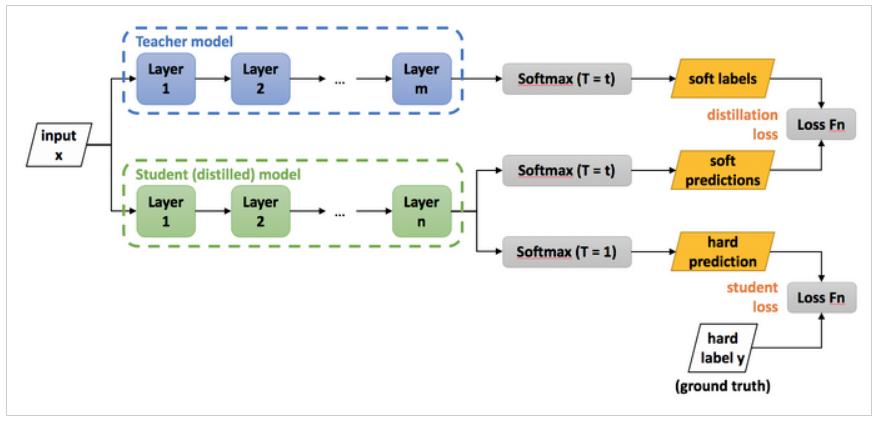

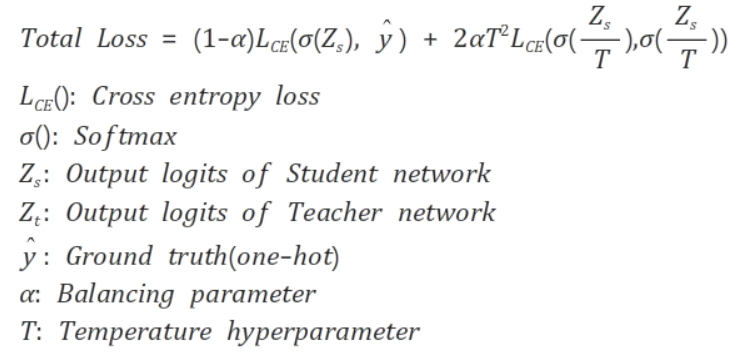